In [ ]:
# default_exp index

# Running distributed training on Google Cloud Platform using [gcp_runner](https://github.com/vlasenkoalexey/gcp_runner) and [nbdev](https://github.com/fastai/nbdev/tree/master/nbdev)

> This projects demonstrates how to run distributed training for TensorFlow Keas and Estimator columnar models on Google Cloud Platform. As a data source public [Criteo Kaggle dataset](https://www.kaggle.com/c/criteo-display-ad-challenge/data) is used.
Project also demonstrates how to import and process data using BigQuery and train models using [BigQuery reader](https://github.com/tensorflow/io/tree/master/tensorflow_io/bigquery). Jupyter notebooks in this projects are converted into Python package using [nbdev](https://github.com/fastai/nbdev/tree/master/nbdev), and [gcp_runner](https://github.com/vlasenkoalexey/gcp_runner) provides a straightforward way of running code from Jupyter notebooks on Google Cloud AI Platform or on Kubernetes without any modifications.
Models can be trained in all distributed modes supported by TensorFlow.


## Setup

In order to run this samples locally, just clone this repository and run Jupyter lab or Jupyter notebook from the same folder.

Jupyter lab can be installed as following:
```sh
pip install jupyterlab
jupyter lab
```

In order to run samples on Google Cloud, it is necessary to install and configure Google Cloud SDK.
Follow steps from `setup.ipynb` to do that.

If you change some of the code on any other Jupyter notebook, use following command to regenerate package and reload all Python modules: 

In [29]:
from gcp_runner.core import export_and_reload_all
export_and_reload_all(silent=True, ignore_errors=False)

## Training locally

Import modules, initialize dependencies

In [39]:
#export
from criteo_nbdev import trainer
from criteo_nbdev.constants import *
from gcp_runner.ai_platform_constants import *

import logging
logging.getLogger().setLevel(logging.INFO)

Declare a helper function in a cell marked with `#export` attribute, notebook also has to have `#default_exp <name>` defined at the top. See `05_trainer.ipynb` for trainer code definition.

In [ ]:
#export
def train_and_evaluate_keras_small(distribution_strategy=None, job_dir=None, **kwargs):
    trainer.train_and_evaluate_keras(job_dir, epochs=3, dataset_size=DATASET_SIZE_TYPE.tiny, distribution_strategy=distribution_strategy)
    
def train_and_evaluate_estimator_small(distribution_strategy=None, job_dir=None, **kwargs):
    trainer.train_and_evaluate_estimator(job_dir, epochs=3, dataset_size=DATASET_SIZE_TYPE.tiny, distribution_strategy=distribution_strategy)

Run training in Jupyter notebook as usual

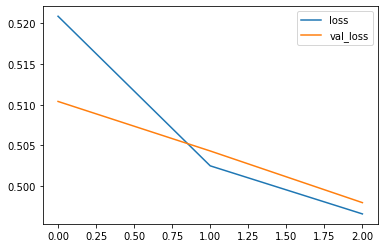

976/976 [==============================] - 75s 77ms/step - loss: 0.4966 - accuracy: 0.7662 - val_loss: 0.4980 - val_accuracy: 0.7649


INFO:root:done training keras model, evaluating model


976/976 [==============================] - 30s 31ms/step - loss: 0.4981 - accuracy: 0.7648


INFO:root:Eval - Loss: 0.498141903079069, Accuracy: 0.76478511095047
INFO:root:None
INFO:root:done evaluating keras model


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_layer (DenseFeatures multiple                  41930697  
_________________________________________________________________
dense_8 (Dense)              multiple                  540592    
_________________________________________________________________
dense_9 (Dense)              multiple                  358202    
_________________________________________________________________
dense_10 (Dense)             multiple                  358202    
_________________________________________________________________
dense_11 (Dense)             multiple                  599       
Total params: 43,188,292
Trainable params: 43,188,292
Non-trainable params: 0
_________________________________________________________________


In [34]:
train_and_evaluate_keras_small(job_dir='./models/model_1')

Running same code locally, but in a Docker container. Only special requirement to be able to run this, is to have gcp_runner project installed in Docker.

In [ ]:
import gcp_runner.local_runner
gcp_runner.local_runner.run_docker(
    train_and_evaluate_keras_small, 
    'gcr.io/alekseyv-scalableai-dev/criteo-nbdev', 
    build_docker_file='./Dockerfile', 
    job_dir='./models/model_docker_1')

To see what this function is doing without running any code, add `dry_run=True`.
In this case it is running following:

```sh
docker build -f ./Dockerfile -t gcr.io/alekseyv-scalableai-dev/criteo-nbdev ./
docker run -v /Users/alekseyv/vlasenkoalexey/criteo_nbdev/criteo_nbdev:/criteo_nbdev \ 
    gcr.io/alekseyv-scalableai-dev/criteo-nbdev \
    python -u -m gcp_runner.entry_point \
    --module-name=criteo_nbdev.index \
    --function-name=train_and_evaluate_keras_small \
    --job-dir=./models/model_docker_1
```

In other words, it is building a Docker container which has a python module `criteo_nbdev.index` with a function to execute
`train_and_evaluate_keras_small`. And it passes this information along with additional arguments to the gcp_runner.entry_point that loads
package and invokes specified function with arguments.

## Running on Google Cloud AI Platform

If everything running in Docker locally worked as expected, and Google Cloud SDK is installed and configured, same code can be runned on Cloud AI Platform as following:

In [ ]:
import gcp_runner.ai_platform_runner

gcp_runner.ai_platform_runner.run_docker_image(
     train_and_evaluate_keras_small,
     'gs://alekseyv-scalableai-dev-criteo-model-bucket/models/model_{username}_{datetime}',
     master_image_uri='gcr.io/alekseyv-scalableai-dev/criteo-nbdev',
     build_docker_file='./Dockerfile',
     region='us-west1')

And same code can be executed using any distributed strategy whithout modifications.
For Keras, you can use `use_distribution_strategy_scope=True` argument. It argument is set to true, code is going to be executed within that strategy scope.

In [ ]:
import gcp_runner.ai_platform_runner

gcp_runner.ai_platform_runner.run_docker_image(
     train_and_evaluate_keras_small,
     'gs://alekseyv-scalableai-dev-criteo-model-bucket/models/model_ms_{username}_{datetime}',
     master_image_uri='gcr.io/alekseyv-scalableai-dev/criteo-nbdev',
     build_docker_file='./Dockerfile',
     region='us-west1',
     distribution_strategy_type = DistributionStrategyType.MIRRORED_STRATEGY,
     use_distribution_strategy_scope=True)

In this case following gcloud command is executed:

```sh
gcloud ai-platform jobs submit training ai_platform_runner_train_docker_20200402_182501 \ 
 --stream-logs \ 
 --job-dir=gs://alekseyv-scalableai-dev-criteo-model-bucket/models/model_ms_alekseyv_20200402_182501 \ 
 --region=us-west1 \ 
 --scale-tier=custom \ 
 --master-machine-type=n1-standard-4 \ 
 --master-image-uri=gcr.io/alekseyv-scalableai-dev/criteo-nbdev \ 
 --master-accelerator=count=2,type=nvidia-tesla-k80 \ 
 --use-chief-in-tf-config=True \ 
 -- python -u -m gcp_runner.entry_point \ 
 --module-name=criteo_nbdev.index \ 
 --function-name=train_and_evaluate_keras_small \ 
 --job-dir=gs://alekseyv-scalableai-dev-criteo-model-bucket/models/model_ms_alekseyv_20200402_182501 \ 
 --distribution-strategy-type=tf.distribute.MirroredStrategy \ 
 --use-distribution-strategy-scope
```

## Running on Kubernetes

Usually it takes few minutes for Job to be provisioned on Google Cloud AI platform, which is not perfect for experimentation and iterative development. 

In order to iterate faster, it is possible to setup a Kubernetes cluster of desired configuration, and use gcp_runner to run code on Kubernetes in a same manner. Distributed training is also supported on Kubernetes.

In [ ]:
import gcp_runner.ai_platform_constants

import gcp_runner.kubernetes_runner
gcp_runner.kubernetes_runner.run_docker_image(
     train_and_evaluate_keras_model_small,
     'gs://alekseyv-scalableai-dev-criteo-model-bucket/test-job-dir/model_mirrored_strategy_{username}_{datetime}',
     image_uri='gcr.io/alekseyv-scalableai-dev/criteo-nbdev',
     build_docker_file='./Dockerfile',
     distribution_strategy_type = gcp_runner.ai_platform_constants.DistributionStrategyType.MIRRORED_STRATEGY,
     use_distribution_strategy_scope=True)